In [1]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
!git clone https://github.com/liuyunhaozz/drone.git

Cloning into 'drone'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 68 (delta 0), reused 65 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [22]:
!cd drone && git pull

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/liuyunhaozz/drone
   b2578ef..68bb1d8  main       -> origin/main
Updating b2578ef..68bb1d8
Fast-forward
 trainval1.json | 1399 ++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 1399 insertions(+)
 create mode 100644 trainval1.json


In [4]:
img_dir = os.listdir('drone/images')
print(len(img_dir))

63


In [27]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("object2", {}, "./drone/trainval.json", "./drone/images")

In [28]:
fruits_nuts_metadata = MetadataCatalog.get("object2")
dataset_dicts = DatasetCatalog.get("object2")

[07/11 07:47:35 d2.data.datasets.coco]: Loaded 63 images in COCO format from ./drone/trainval.json


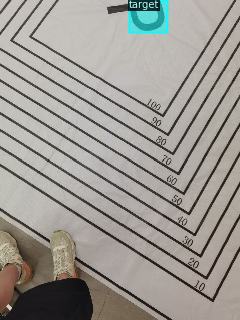

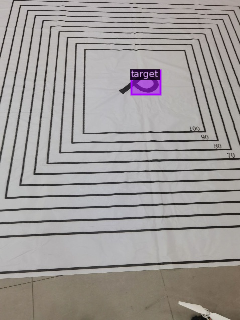

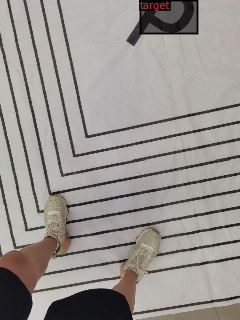

In [29]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12533, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 12533 (delta 8), reused 14 (delta 5), pack-reused 12506
Receiving objects: 100% (12533/12533), 5.25 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (8969/8969), done.


In [31]:
# 训练模型专用（读取已有模型则不用运行）
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")
cfg.DATASETS.TRAIN = ("object",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-101.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 12   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/11 07:49:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

In [32]:
# 仅在训练完模型后运行
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("object", )
predictor = DefaultPredictor(cfg)

Boxes(tensor([[274.1245,   0.0000, 353.7682,  32.5204]], device='cuda:0'))


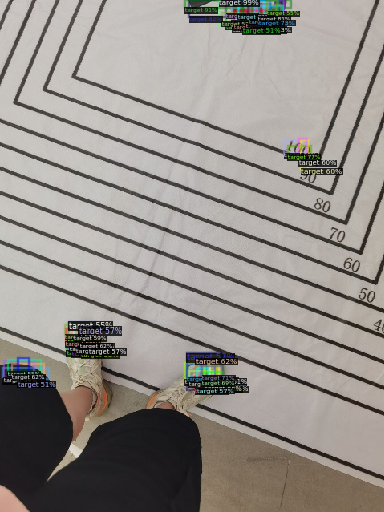

Boxes(tensor([[224.6747, 255.8973, 266.4701, 280.2133]], device='cuda:0'))


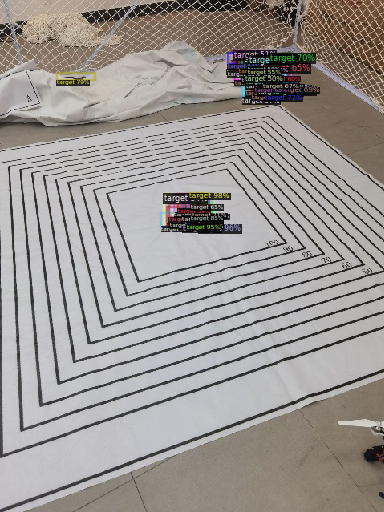

Boxes(tensor([[223.5018, 146.8129, 303.7632, 202.7346]], device='cuda:0'))


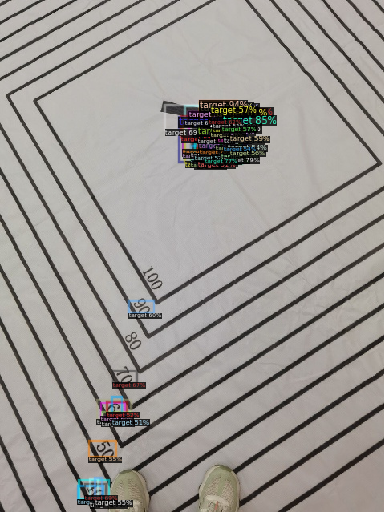

In [33]:
# 测试模型
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    # print(outputs)
    print(outputs['instances'].get_fields()['pred_boxes'][0])
    # print(outputs['instances'].fields)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [57]:
!cd output && ls -lh

total 335M
-rw-r--r-- 1 root root  16K Jul 11 06:15 events.out.tfevents.1625984018.6615d6e62ef3.158.0
-rw-r--r-- 1 root root  34K Jul 11 06:55 events.out.tfevents.1625986292.6615d6e62ef3.158.1
-rw-r--r-- 1 root root   15 Jul 11 06:15 last_checkpoint
-rw-r--r-- 1 root root  33K Jul 11 06:55 metrics.json
-rw-r--r-- 1 root root 335M Jul 11 06:15 model_final.pth


In [19]:
!rm -rf output